# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:09<00:00, 6.34KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

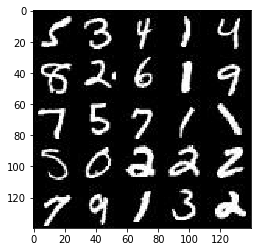

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

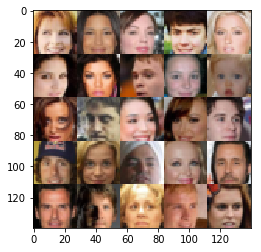

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


/home/edwardshyu/anaconda3/envs/tf1_1_cpu/lib/python3.5/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [20]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width,image_height, image_channels), name="input_real")
    input_z = tf.placeholder(tf.float32, (None, z_dim), name="input_z")
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def leaky_relu(x, alpha=0.2):
    return tf.maximum(alpha * x, x)

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha=0.2
        
        #Input 28x28x3
        conv1 = tf.layers.conv2d(inputs=images,
                                 filters=64,
                                 kernel_size=3,
                                 strides=2,
                                 padding='same')
        '''
        first layer doesn't use batch normalization because we've already
        normalized the input images
        '''
        activ1 = leaky_relu(conv1, alpha)
        #layer 1 output is 14 x 14 x 64
        
        conv2 = tf.layers.conv2d(inputs=activ1,
                                 filters=128,
                                 kernel_size=3,
                                 strides=2,
                                 padding='same')
        norm2 = tf.layers.batch_normalization(inputs=conv2, training=True)
        activ2 = leaky_relu(norm2, alpha)
        #layer 2 output is 7 x 7 x 128
        
        conv3 = tf.layers.conv2d(inputs=activ2,
                                 filters=256,
                                 kernel_size=3,
                                 strides=1,
                                 padding='same')
        norm3 = tf.layers.batch_normalization(inputs=conv3, training=True)
        activ3 = leaky_relu(norm3, alpha)
        #layer 3 output is 7 x 7 x 256
        
        ''' 
        flatten tensor to one row, columns equals num of elements in 3rd conv layer,
        which is 7 * 7 * 256;
        Technically, the first dimension will be more than one row
        because we're passing in batches of more than one image,
        so the first dimension should equal the batch size
        '''
        flat = tf.reshape(tensor=activ3, shape=[-1,7*7*256])
        
        #fully connected layer outputs just 1 scalar, 1 for real images, 0 for fake images
        logits = tf.layers.dense(inputs=flat, units=1)
        out = tf.sigmoid(logits)
        
    '''
    return both the 'out' prediction and the logits
    before applying activation.  
    This is because when we apply cross entropy, it's more efficient
    to combine it with the sigmoid activation, so we'll use a function 
    that combines both in one function: 
    tf.nn.sigmoid_cross_entropy_with_logits
    '''    
    return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    '''
    When we are training, we do not reuse the variables; we start with fresh random variables.
    When we are not training, but testing, we want to re-use the variable and weights
    that were found previously during training.
    '''
    reuse = not is_train
    alpha=0.2
    with tf.variable_scope('generator', reuse=reuse):
        '''
        Start by passing the input noise thru fully connected layer,
        so that we can start with the desired number of units
        '''
        dense1 = tf.layers.dense(inputs=z, units=7*7*512)
        #create first conv layer: batch size x width x height x channels
        conv1 = tf.reshape(tensor=dense1, shape=[-1,7,7,512])
        norm1 = tf.layers.batch_normalization(inputs=conv1, training=is_train)
        activ1 = leaky_relu(norm1, alpha)
        #size: 7 x 7 x 512
        
        '''
        up-sampling to increase width and height
        Convolution transpose increases the width and height of output
        by a factor of stride size.
        '''
        conv2 = tf.layers.conv2d_transpose(inputs=activ1,
                                           filters=256,
                                           kernel_size=3,
                                           strides=2,
                                           padding='same')
        norm2 = tf.layers.batch_normalization(inputs=conv2, training=is_train)
        activ2 = leaky_relu(norm2, alpha)
        #size: 14 x 14 x 256
        
        conv3 = tf.layers.conv2d_transpose(inputs=activ2,
                                           filters=128,
                                           kernel_size=3,
                                           strides=2,
                                           padding='same')
        norm3 = tf.layers.batch_normalization(inputs=conv3, training=is_train)
        activ3 = leaky_relu(norm3, alpha)
        #size 28 x 28 x 128
        
        
        #output layer (filters should be 3, for rgb channels)
        logits = tf.layers.conv2d_transpose(inputs=activ3,
                                            filters=out_channel_dim,
                                            kernel_size=3,
                                            strides=1,
                                            padding='same')
        
        #size: 28 x 28 x 3: same shape as the real images
        #output ranges from -1 to 1, so use tanh
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    '''
    The generator is training, and does not reuse the variables (starts with fresh weights)
    The discriminator views real images and does not reuse variables.
    The discriminator views fake images and reuses variables that are being used when training on real images
    '''
    g_model = generator(z=input_z,
                        out_channel_dim=out_channel_dim,
                        is_train=True)
    d_model_real, d_logits_real = discriminator(images=input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(images=g_model, reuse=True)
    '''
    We can use sigmoid and not softmax here because it's just a single unit output 
    between 0 and 1; softmax would give us the same thing, but it's only needed when there
    are more than one classes (output units), because we want all the outputs to sum to 100%
    
    For generator, its goal is to make its fake output be labeled as ones (as real images).
    
    For the discriminator, its goal is to label real images as 1, and generator images as 0.
    For real images, labels should be ones. d_model_real and d_logits_real have the same shape, 
    so we can use either to create the labels; it's more clear to use d_model_real, because it's
    the sigmoid output between 0 and 1, and the labels should also be between 0 and 1
    '''
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake))
    )
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    '''
    We want the discriminator's optimizer to only train the discriminator variables,
    likewise, the generator optimizer only modifies the generator variables
    '''
    tvars = tf.trainable_variables()
    d_vars = [var for var in tvars if var.name.startswith('discriminator')]
    g_vars = [var for var in tvars if var.name.startswith('generator')]
    
    '''
    Use control_dependencies so that batch normalization can update their population statistics.
    
    '''
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate,
                                             beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate,
                                             beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [40]:
class GAN:
    def __init__(self, real_size, z_size, learning_rate, alpha=0.2, beta1=0.5):
        tf.reset_default_graph()
        #model_inputs(image_width, image_height, image_channels, z_dim)
        self.input_real, self.input_z, learning_rate_ = model_inputs(image_width=real_size[0],image_height=real_size[1],image_channels=real_size[2],z_dim=z_size)
        
        #model_loss(input_real, input_z, out_channel_dim)
        self.d_loss, self.g_loss = model_loss(input_real=self.input_real,
                                              input_z=self.input_z,
                                              out_channel_dim=real_size[2])
        
        #model_opt(d_loss, g_loss, learning_rate, beta1)
        self.d_opt, self.g_opt = model_opt(d_loss=self.d_loss,
                                           g_loss=self.g_loss,
                                           learning_rate=learning_rate,
                                           beta1=beta1)

And another function we can use to train our network. Notice when we call `generator` to create the samples to display, we set `training` to `False`. That's so the batch normalization layers will use the population statistics rather than the batch statistics. Also notice that we set the `net.input_real` placeholder when we run the generator's optimizer. The generator doesn't actually use it, but we'd get an error without it because of the `tf.control_dependencies` block we created in `model_opt`. 

In [54]:
def train(gan, epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """

    
    '''
    re-use the same generator input when checking the progress of training with sample output images
    
    data_shape for mnist looks like:
    (60000, 28, 28, 1)
    batch_size, width, height, channels
    use data_shape[3] to get the channel size
    '''
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))
    samples, losses = [], []
    steps=0
    n_images = 12 # num of generated images to show when checking progress
    out_channel_dim = data_shape[3]
    print_every=10
    show_every=20
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        saver = tf.train.Saver()
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps +=1
                #input for generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                #optimizers
                '''
                Also notice that we set the `net.input_real` placeholder when we run the generator's optimizer. 
                The generator doesn't actually use it, 
                but we'd get an error without it because of the `tf.control_dependencies` block 
                we created in `model_opt`. 
                '''
                _ = sess.run(gan.d_opt, feed_dict={gan.input_real: batch_images, gan.input_z: batch_z})
                _ = sess.run(gan.g_opt, feed_dict={gan.input_z: batch_z, gan.input_real: batch_images})
                
                if steps % print_every == 0:
                    train_loss_d = sess.run(gan.d_loss, feed_dict={gan.input_z: batch_z, gan.input_real: batch_images})
                    train_loss_g = sess.run(gan.g_loss, feed_dict={gan.input_z: batch_z})
                    
                    print("Epoch {}/{}".format(epoch_i+1, epoch_count),
                          "Discriminator loss {:.4f}".format(train_loss_d),
                          "Generator loss {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d,train_loss_g))
                    
                if steps % show_every == 0:
                    show_generator_output(sess=sess,
                                          n_images=n_images,
                                          input_z=gan.input_z,
                                          out_channel_dim=out_channel_dim,
                                          image_mode=data_image_mode)
        saver.save(sess, "./checkpoints/generator.ckpt")
        
    with open("samples.pkl", "wb") as f:
        pkl.dump(samples,f)
        
    return losses, samples

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2 Discriminator loss 1.6421 Generator loss 0.3825
Epoch 1/2 Discriminator loss 1.5922 Generator loss 1.4898


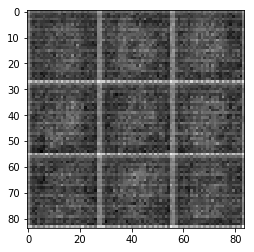

Epoch 1/2 Discriminator loss 1.2410 Generator loss 1.9393
Epoch 1/2 Discriminator loss 1.2725 Generator loss 0.8792


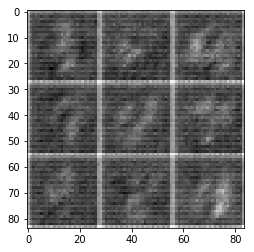

Epoch 1/2 Discriminator loss 1.0842 Generator loss 1.6186
Epoch 1/2 Discriminator loss 0.7314 Generator loss 0.9368


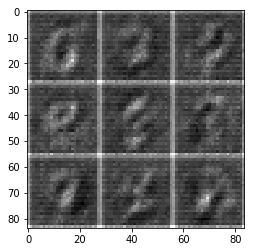

Epoch 1/2 Discriminator loss 0.5176 Generator loss 1.5354
Epoch 1/2 Discriminator loss 0.4458 Generator loss 1.2768


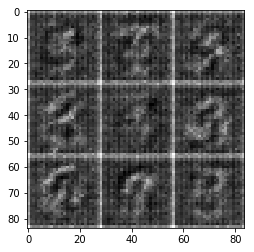

Epoch 1/2 Discriminator loss 0.2538 Generator loss 1.9100
Epoch 1/2 Discriminator loss 0.1587 Generator loss 2.2203


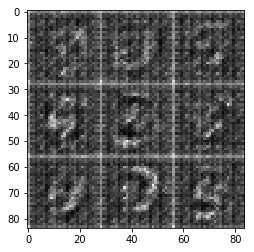

Epoch 1/2 Discriminator loss 0.1423 Generator loss 2.3922
Epoch 1/2 Discriminator loss 0.0654 Generator loss 4.0086


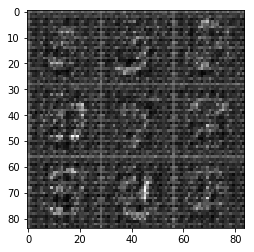

Epoch 1/2 Discriminator loss 0.2002 Generator loss 1.8506
Epoch 1/2 Discriminator loss 0.0598 Generator loss 3.4170


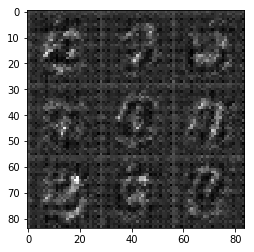

Epoch 1/2 Discriminator loss 0.0706 Generator loss 3.1438
Epoch 1/2 Discriminator loss 0.0465 Generator loss 3.4832


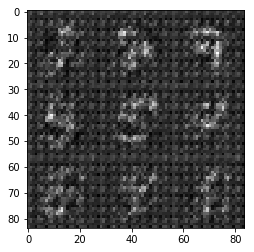

Epoch 1/2 Discriminator loss 0.3413 Generator loss 4.1495
Epoch 1/2 Discriminator loss 0.2269 Generator loss 2.1340


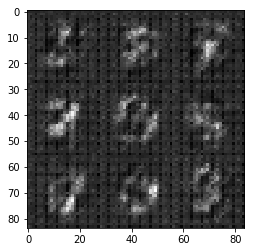

Epoch 1/2 Discriminator loss 0.0865 Generator loss 3.7356
Epoch 1/2 Discriminator loss 0.0496 Generator loss 5.2440


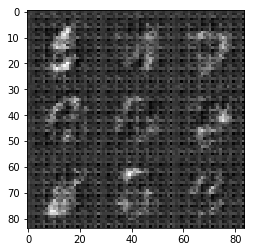

Epoch 1/2 Discriminator loss 0.0378 Generator loss 5.4804
Epoch 1/2 Discriminator loss 0.0975 Generator loss 2.8256


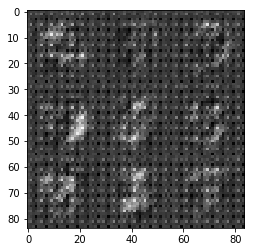

Epoch 1/2 Discriminator loss 1.2762 Generator loss 8.0262
Epoch 1/2 Discriminator loss 0.0488 Generator loss 6.0039


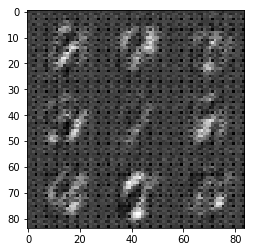

Epoch 1/2 Discriminator loss 0.0785 Generator loss 2.9014
Epoch 1/2 Discriminator loss 0.0714 Generator loss 4.1042


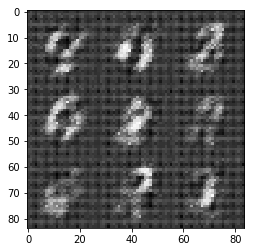

Epoch 1/2 Discriminator loss 0.6868 Generator loss 6.1399
Epoch 1/2 Discriminator loss 0.6219 Generator loss 1.2668


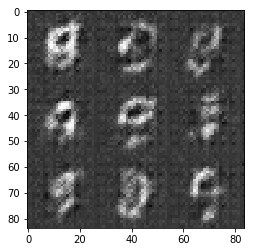

Epoch 1/2 Discriminator loss 0.1051 Generator loss 4.1855
Epoch 1/2 Discriminator loss 0.3833 Generator loss 1.5113


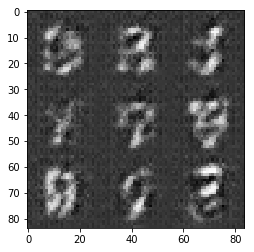

Epoch 1/2 Discriminator loss 0.1647 Generator loss 2.3901
Epoch 1/2 Discriminator loss 0.0708 Generator loss 3.9364


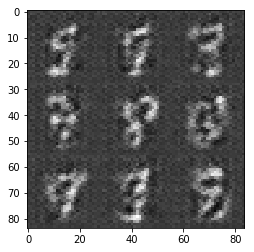

Epoch 1/2 Discriminator loss 0.3373 Generator loss 1.7412
Epoch 1/2 Discriminator loss 0.0999 Generator loss 3.1254


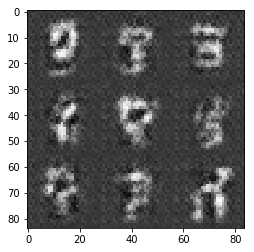

Epoch 1/2 Discriminator loss 0.1215 Generator loss 3.7446
Epoch 1/2 Discriminator loss 0.1363 Generator loss 2.7194


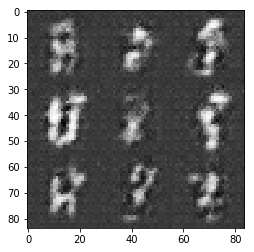

Epoch 1/2 Discriminator loss 2.5453 Generator loss 0.0983
Epoch 1/2 Discriminator loss 0.1931 Generator loss 2.4142


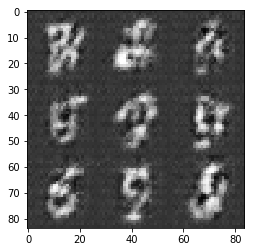

Epoch 1/2 Discriminator loss 0.0985 Generator loss 3.3690
Epoch 1/2 Discriminator loss 0.4130 Generator loss 5.1172


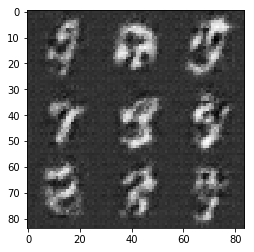

Epoch 1/2 Discriminator loss 0.1313 Generator loss 2.6238
Epoch 1/2 Discriminator loss 0.0539 Generator loss 4.6268


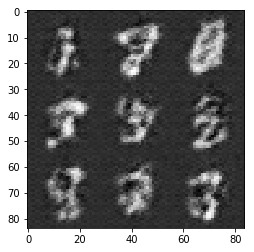

Epoch 1/2 Discriminator loss 0.0907 Generator loss 3.0578
Epoch 1/2 Discriminator loss 0.1120 Generator loss 2.8746


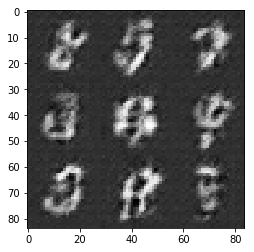

Epoch 1/2 Discriminator loss 0.0418 Generator loss 4.7093
Epoch 1/2 Discriminator loss 0.2270 Generator loss 2.4118


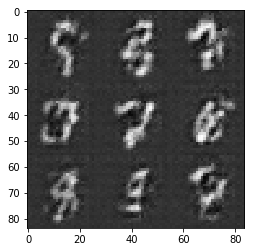

Epoch 2/2 Discriminator loss 0.1781 Generator loss 2.2915
Epoch 2/2 Discriminator loss 0.1172 Generator loss 2.7927


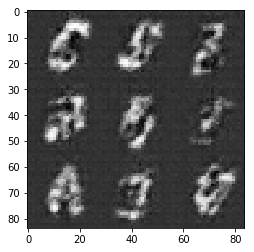

Epoch 2/2 Discriminator loss 0.1245 Generator loss 2.6750
Epoch 2/2 Discriminator loss 0.1028 Generator loss 2.8827


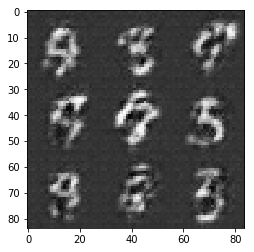

Epoch 2/2 Discriminator loss 0.1192 Generator loss 2.6510
Epoch 2/2 Discriminator loss 0.1548 Generator loss 2.3428


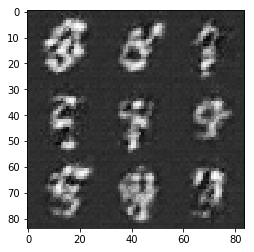

Epoch 2/2 Discriminator loss 0.1514 Generator loss 2.3164
Epoch 2/2 Discriminator loss 0.0634 Generator loss 3.7328


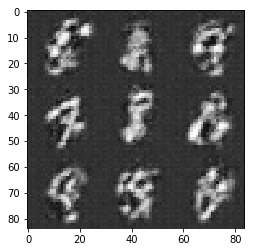

Epoch 2/2 Discriminator loss 0.3249 Generator loss 3.3169
Epoch 2/2 Discriminator loss 0.2206 Generator loss 2.2690


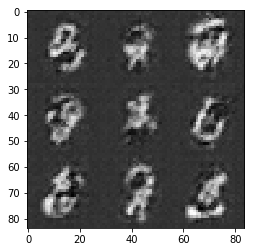

Epoch 2/2 Discriminator loss 0.1297 Generator loss 2.8993
Epoch 2/2 Discriminator loss 0.1574 Generator loss 2.4833


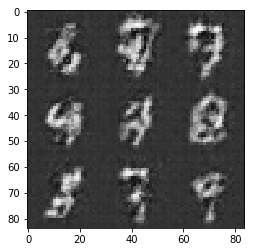

Epoch 2/2 Discriminator loss 0.0757 Generator loss 3.5092
Epoch 2/2 Discriminator loss 0.2996 Generator loss 1.6527


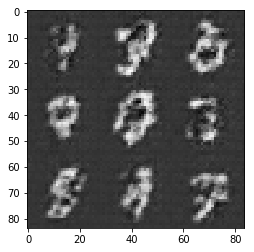

Epoch 2/2 Discriminator loss 0.0878 Generator loss 3.2734
Epoch 2/2 Discriminator loss 0.1720 Generator loss 2.3348


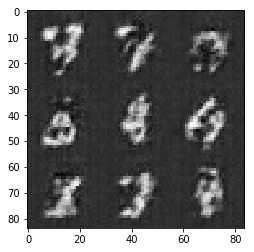

Epoch 2/2 Discriminator loss 0.0315 Generator loss 4.7366
Epoch 2/2 Discriminator loss 0.0541 Generator loss 4.0469


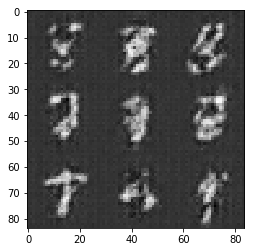

Epoch 2/2 Discriminator loss 0.0702 Generator loss 3.4105
Epoch 2/2 Discriminator loss 0.0445 Generator loss 4.1808


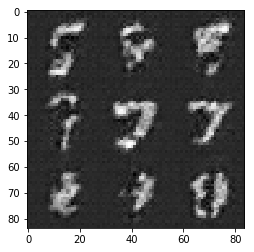

Epoch 2/2 Discriminator loss 0.3552 Generator loss 2.8104
Epoch 2/2 Discriminator loss 0.3136 Generator loss 1.8467


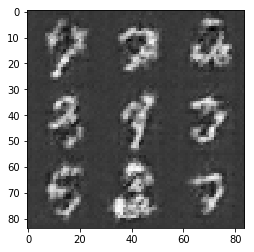

Epoch 2/2 Discriminator loss 0.1439 Generator loss 4.0478
Epoch 2/2 Discriminator loss 0.0641 Generator loss 3.5910


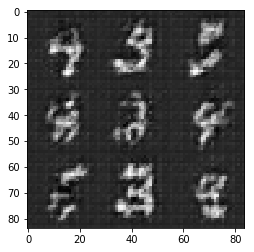

Epoch 2/2 Discriminator loss 0.0650 Generator loss 4.3121
Epoch 2/2 Discriminator loss 0.5473 Generator loss 1.0361


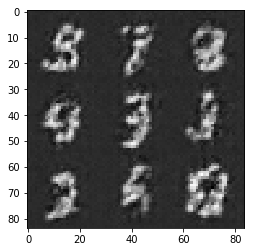

Epoch 2/2 Discriminator loss 0.2615 Generator loss 1.9326
Epoch 2/2 Discriminator loss 0.1732 Generator loss 2.6832


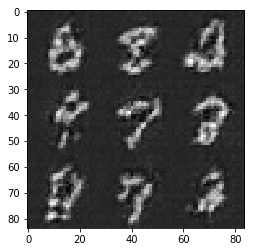

Epoch 2/2 Discriminator loss 0.2173 Generator loss 2.1433
Epoch 2/2 Discriminator loss 0.0875 Generator loss 6.4569


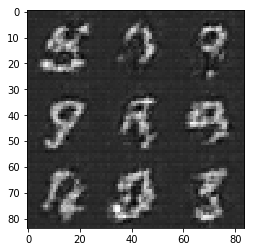

Epoch 2/2 Discriminator loss 0.0826 Generator loss 3.7827
Epoch 2/2 Discriminator loss 0.1285 Generator loss 2.9748


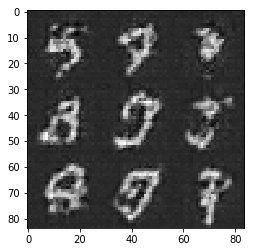

Epoch 2/2 Discriminator loss 0.0215 Generator loss 5.9645
Epoch 2/2 Discriminator loss 0.0813 Generator loss 3.7473


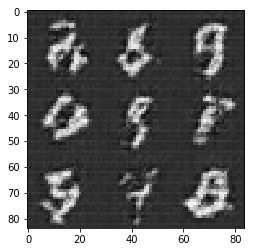

Epoch 2/2 Discriminator loss 0.1789 Generator loss 2.2509
Epoch 2/2 Discriminator loss 0.0559 Generator loss 4.7119


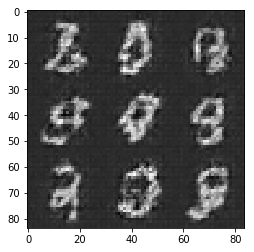

Epoch 2/2 Discriminator loss 0.1206 Generator loss 2.7895
Epoch 2/2 Discriminator loss 0.1031 Generator loss 3.6239


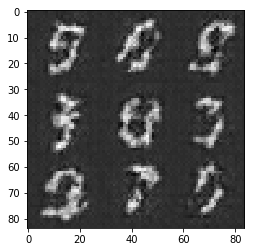

Epoch 2/2 Discriminator loss 0.1055 Generator loss 3.4419
Epoch 2/2 Discriminator loss 0.0541 Generator loss 4.6141


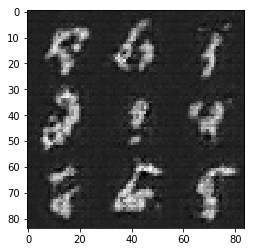

Epoch 2/2 Discriminator loss 0.3476 Generator loss 1.4507
Epoch 2/2 Discriminator loss 0.0572 Generator loss 6.2004


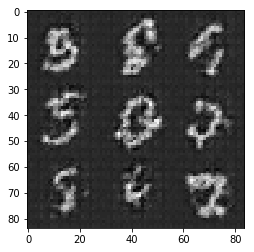

Epoch 2/2 Discriminator loss 0.0388 Generator loss 4.1439
Epoch 2/2 Discriminator loss 0.2707 Generator loss 1.7761


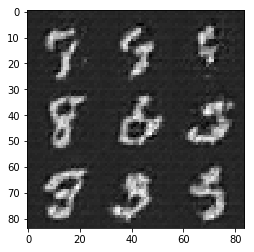

Epoch 2/2 Discriminator loss 0.2436 Generator loss 1.9180
Epoch 2/2 Discriminator loss 0.4389 Generator loss 1.2590


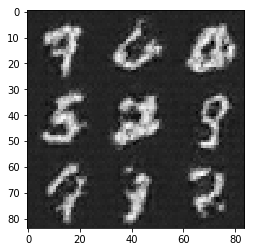

Epoch 2/2 Discriminator loss 1.0814 Generator loss 0.8091


IndexError: list index out of range

In [55]:
batch_size = 128
epochs = 25
learning_rate = 0.0002
real_size = (28,28,1) 
z_dim = 100
alpha = 0.2
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    gan = GAN(real_size=real_size, z_size=z_dim, learning_rate=learning_rate, alpha=alpha, beta1=beta1)
    train(gan,epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1 Discriminator loss 2.7160 Generator loss 0.1528
Epoch 1/1 Discriminator loss 1.6680 Generator loss 0.4675


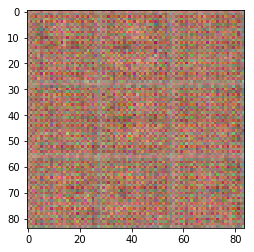

Epoch 1/1 Discriminator loss 1.2050 Generator loss 0.7188
Epoch 1/1 Discriminator loss 1.0256 Generator loss 0.6843


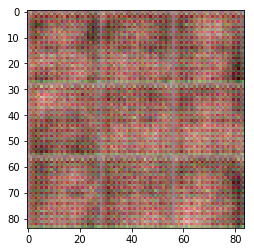

Epoch 1/1 Discriminator loss 0.8958 Generator loss 0.9839
Epoch 1/1 Discriminator loss 0.5822 Generator loss 1.8239


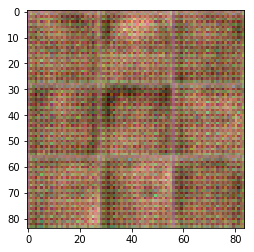

Epoch 1/1 Discriminator loss 0.4611 Generator loss 3.1147
Epoch 1/1 Discriminator loss 0.8231 Generator loss 0.8139


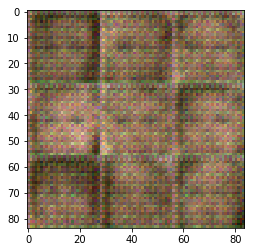

Epoch 1/1 Discriminator loss 0.5792 Generator loss 1.2010
Epoch 1/1 Discriminator loss 0.3158 Generator loss 1.6582


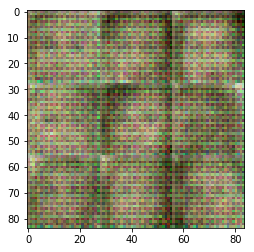

Epoch 1/1 Discriminator loss 0.1593 Generator loss 3.1657
Epoch 1/1 Discriminator loss 0.3205 Generator loss 2.0777


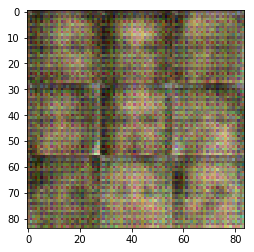

Epoch 1/1 Discriminator loss 0.3170 Generator loss 6.9246
Epoch 1/1 Discriminator loss 0.4761 Generator loss 10.5802


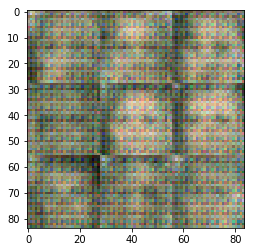

Epoch 1/1 Discriminator loss 0.1503 Generator loss 2.5595
Epoch 1/1 Discriminator loss 0.0418 Generator loss 4.7233


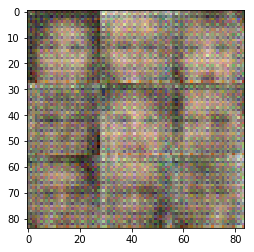

Epoch 1/1 Discriminator loss 0.0737 Generator loss 5.9302
Epoch 1/1 Discriminator loss 1.0041 Generator loss 0.5987


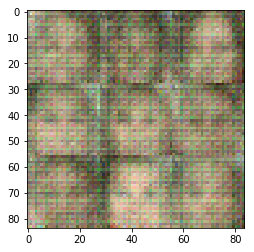

Epoch 1/1 Discriminator loss 3.2596 Generator loss 10.2409
Epoch 1/1 Discriminator loss 0.3219 Generator loss 1.7623


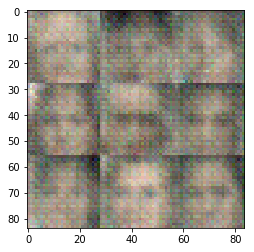

Epoch 1/1 Discriminator loss 0.1298 Generator loss 4.1834
Epoch 1/1 Discriminator loss 0.4262 Generator loss 2.2692


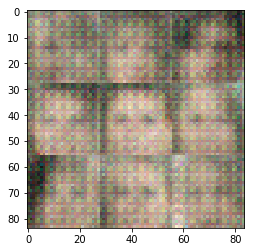

Epoch 1/1 Discriminator loss 0.8618 Generator loss 0.6794
Epoch 1/1 Discriminator loss 0.0338 Generator loss 5.8393


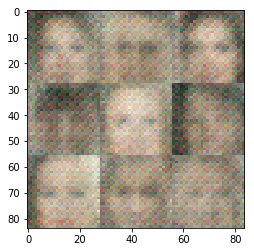

Epoch 1/1 Discriminator loss 0.1046 Generator loss 5.6506
Epoch 1/1 Discriminator loss 0.5558 Generator loss 9.4824


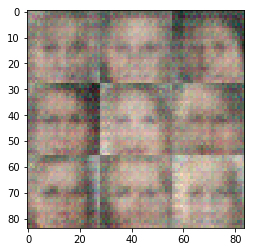

Epoch 1/1 Discriminator loss 0.4985 Generator loss 2.8552
Epoch 1/1 Discriminator loss 0.1295 Generator loss 3.7813


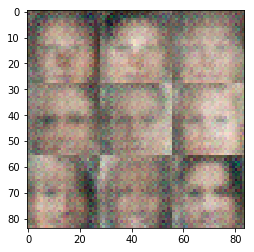

Epoch 1/1 Discriminator loss 0.5881 Generator loss 13.9611
Epoch 1/1 Discriminator loss 2.4316 Generator loss 0.1548


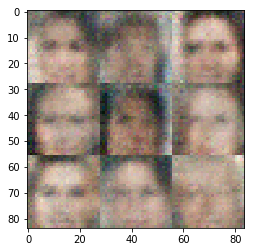

Epoch 1/1 Discriminator loss 0.2404 Generator loss 3.1851
Epoch 1/1 Discriminator loss 2.1190 Generator loss 0.1817


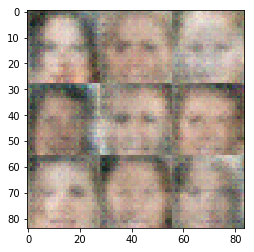

Epoch 1/1 Discriminator loss 1.4797 Generator loss 0.8341
Epoch 1/1 Discriminator loss 0.4059 Generator loss 7.1091


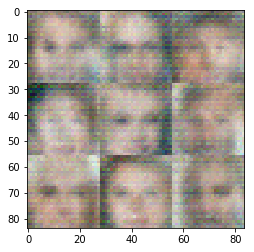

Epoch 1/1 Discriminator loss 1.7796 Generator loss 0.2749
Epoch 1/1 Discriminator loss 1.2847 Generator loss 0.8733


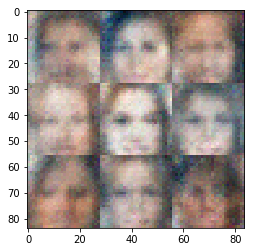

Epoch 1/1 Discriminator loss 1.3722 Generator loss 0.6613
Epoch 1/1 Discriminator loss 1.0451 Generator loss 1.0743


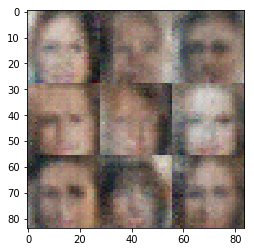

Epoch 1/1 Discriminator loss 1.5534 Generator loss 0.7542
Epoch 1/1 Discriminator loss 1.2834 Generator loss 0.6345


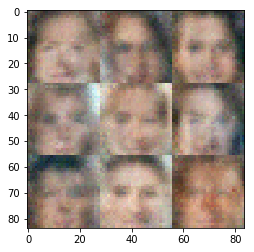

Epoch 1/1 Discriminator loss 1.1879 Generator loss 0.8250
Epoch 1/1 Discriminator loss 1.2525 Generator loss 0.7689


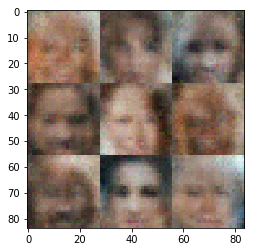

Epoch 1/1 Discriminator loss 1.1793 Generator loss 0.7630
Epoch 1/1 Discriminator loss 1.4087 Generator loss 0.5184


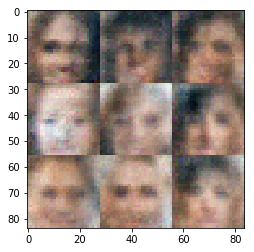

Epoch 1/1 Discriminator loss 1.2195 Generator loss 0.9934
Epoch 1/1 Discriminator loss 1.2359 Generator loss 0.8977


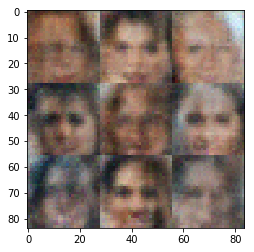

Epoch 1/1 Discriminator loss 1.2653 Generator loss 0.7218
Epoch 1/1 Discriminator loss 1.1344 Generator loss 0.6900


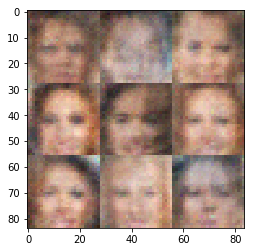

Epoch 1/1 Discriminator loss 1.2979 Generator loss 0.6238
Epoch 1/1 Discriminator loss 1.1163 Generator loss 0.7847


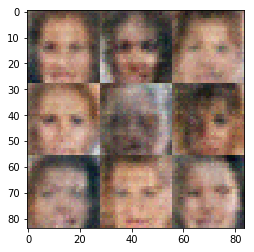

Epoch 1/1 Discriminator loss 0.9886 Generator loss 1.2597
Epoch 1/1 Discriminator loss 1.2379 Generator loss 0.5779


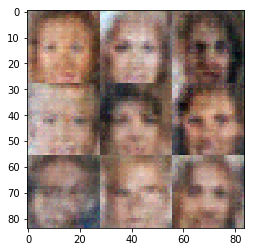

Epoch 1/1 Discriminator loss 1.1293 Generator loss 0.7996
Epoch 1/1 Discriminator loss 1.0732 Generator loss 0.9186


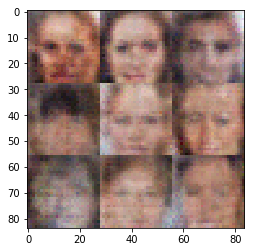

Epoch 1/1 Discriminator loss 1.4336 Generator loss 0.3810
Epoch 1/1 Discriminator loss 0.8543 Generator loss 0.9866


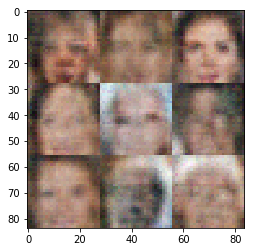

Epoch 1/1 Discriminator loss 0.5612 Generator loss 1.1972
Epoch 1/1 Discriminator loss 0.6652 Generator loss 0.9935


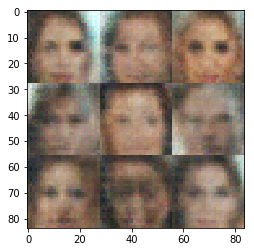

Epoch 1/1 Discriminator loss 1.1897 Generator loss 0.4857
Epoch 1/1 Discriminator loss 0.0738 Generator loss 7.3169


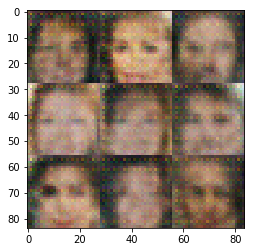

Epoch 1/1 Discriminator loss 0.4953 Generator loss 1.2361
Epoch 1/1 Discriminator loss 0.5555 Generator loss 1.0086


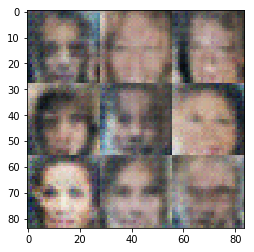

Epoch 1/1 Discriminator loss 0.0606 Generator loss 7.8252
Epoch 1/1 Discriminator loss 0.1748 Generator loss 11.2302


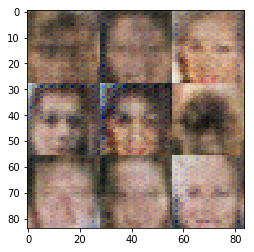

Epoch 1/1 Discriminator loss 2.7907 Generator loss 0.0726
Epoch 1/1 Discriminator loss 0.5961 Generator loss 0.9451


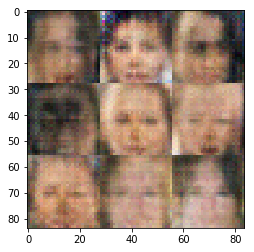

Epoch 1/1 Discriminator loss 0.1075 Generator loss 4.9026
Epoch 1/1 Discriminator loss 0.4302 Generator loss 3.6876


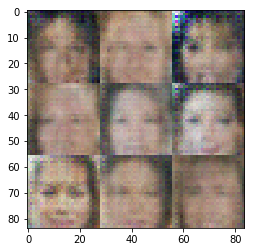

Epoch 1/1 Discriminator loss 0.2059 Generator loss 2.3676
Epoch 1/1 Discriminator loss 0.1777 Generator loss 12.0254


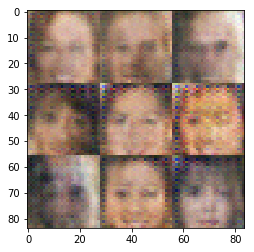

Epoch 1/1 Discriminator loss 1.6486 Generator loss 0.2951
Epoch 1/1 Discriminator loss 0.2840 Generator loss 2.6927


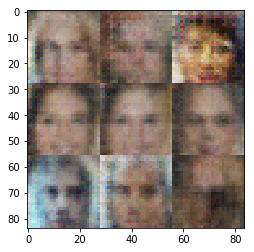

Epoch 1/1 Discriminator loss 0.3703 Generator loss 1.9227
Epoch 1/1 Discriminator loss 0.1601 Generator loss 3.4998


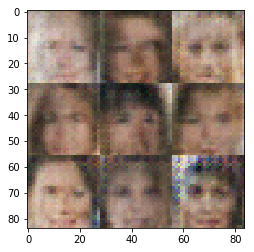

Epoch 1/1 Discriminator loss 0.6429 Generator loss 1.5299
Epoch 1/1 Discriminator loss 1.2745 Generator loss 0.5232


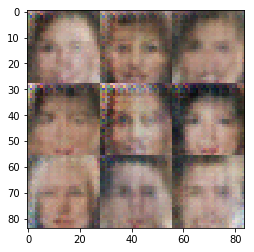

Epoch 1/1 Discriminator loss 1.4817 Generator loss 0.3938
Epoch 1/1 Discriminator loss 0.2442 Generator loss 8.8648


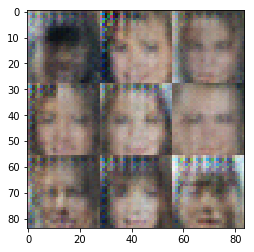

Epoch 1/1 Discriminator loss 0.4811 Generator loss 2.8929
Epoch 1/1 Discriminator loss 0.2046 Generator loss 2.7557


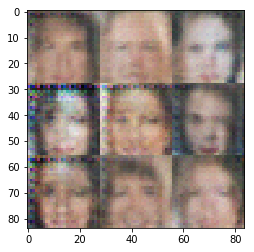

Epoch 1/1 Discriminator loss 0.4228 Generator loss 1.7435
Epoch 1/1 Discriminator loss 0.0442 Generator loss 9.5289


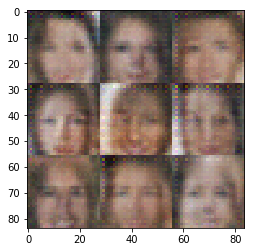

Epoch 1/1 Discriminator loss 0.1104 Generator loss 3.6781
Epoch 1/1 Discriminator loss 0.8690 Generator loss 0.7626


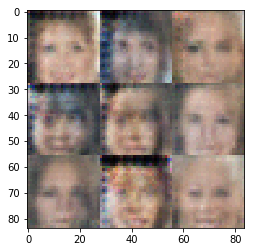

Epoch 1/1 Discriminator loss 0.8309 Generator loss 7.9066
Epoch 1/1 Discriminator loss 0.0400 Generator loss 4.9856


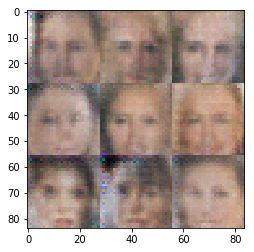

Epoch 1/1 Discriminator loss 0.0392 Generator loss 4.6174
Epoch 1/1 Discriminator loss 0.1912 Generator loss 2.9526


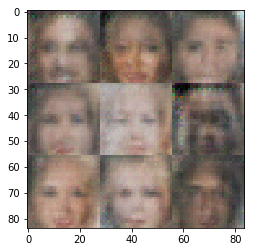

Epoch 1/1 Discriminator loss 0.1649 Generator loss 3.0064
Epoch 1/1 Discriminator loss 2.1584 Generator loss 0.2598


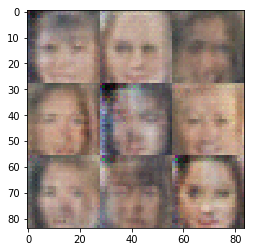

Epoch 1/1 Discriminator loss 0.3302 Generator loss 3.3095
Epoch 1/1 Discriminator loss 0.6160 Generator loss 1.7093


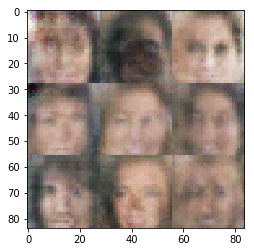

Epoch 1/1 Discriminator loss 0.1963 Generator loss 2.9804
Epoch 1/1 Discriminator loss 0.3967 Generator loss 1.7626


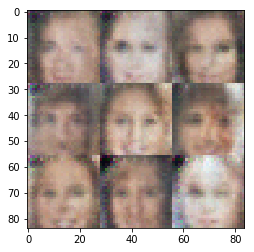

Epoch 1/1 Discriminator loss 0.1048 Generator loss 6.5025
Epoch 1/1 Discriminator loss 0.0721 Generator loss 4.3835


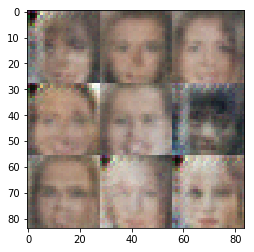

Epoch 1/1 Discriminator loss 0.6495 Generator loss 1.5331
Epoch 1/1 Discriminator loss 0.1072 Generator loss 3.2405


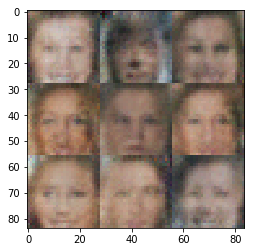

Epoch 1/1 Discriminator loss 0.4516 Generator loss 1.9721
Epoch 1/1 Discriminator loss 0.2256 Generator loss 2.8902


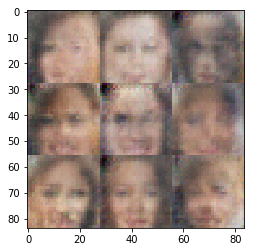

Epoch 1/1 Discriminator loss 0.2795 Generator loss 2.3828
Epoch 1/1 Discriminator loss 0.1240 Generator loss 4.2578


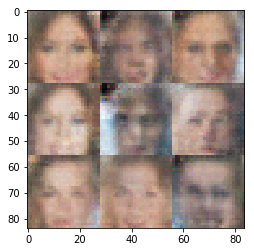

Epoch 1/1 Discriminator loss 0.2809 Generator loss 2.3471
Epoch 1/1 Discriminator loss 0.5781 Generator loss 1.4890


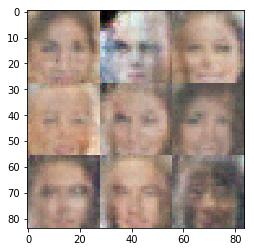

Epoch 1/1 Discriminator loss 0.3746 Generator loss 5.7315
Epoch 1/1 Discriminator loss 0.1670 Generator loss 6.2990


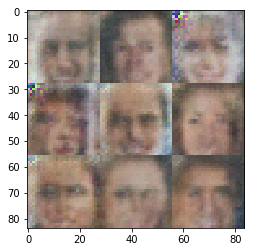

Epoch 1/1 Discriminator loss 0.2999 Generator loss 3.6951
Epoch 1/1 Discriminator loss 0.0754 Generator loss 6.4305


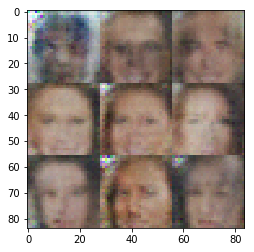

Epoch 1/1 Discriminator loss 0.1682 Generator loss 5.0353
Epoch 1/1 Discriminator loss 0.0488 Generator loss 7.2729


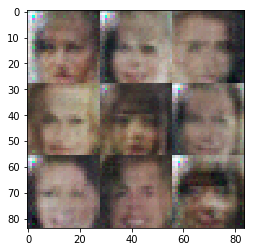

Epoch 1/1 Discriminator loss 0.2277 Generator loss 3.1224
Epoch 1/1 Discriminator loss 0.2823 Generator loss 4.5344


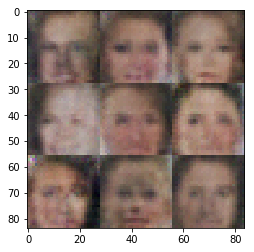

Epoch 1/1 Discriminator loss 0.1718 Generator loss 3.4057
Epoch 1/1 Discriminator loss 0.3680 Generator loss 1.8981


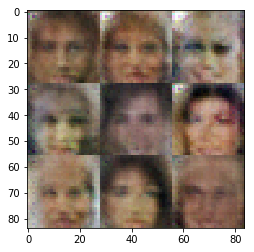

Epoch 1/1 Discriminator loss 0.2313 Generator loss 3.4571
Epoch 1/1 Discriminator loss 0.3574 Generator loss 2.0734


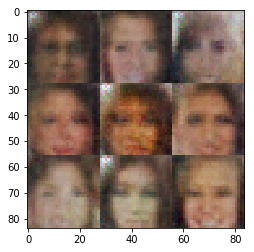

Epoch 1/1 Discriminator loss 0.1437 Generator loss 3.1235
Epoch 1/1 Discriminator loss 0.3802 Generator loss 2.4593


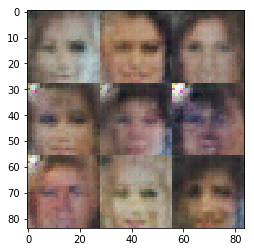

Epoch 1/1 Discriminator loss 0.1323 Generator loss 6.2070
Epoch 1/1 Discriminator loss 0.4954 Generator loss 5.5242


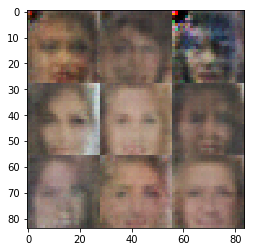

Epoch 1/1 Discriminator loss 0.4094 Generator loss 3.9028
Epoch 1/1 Discriminator loss 0.6305 Generator loss 3.9505


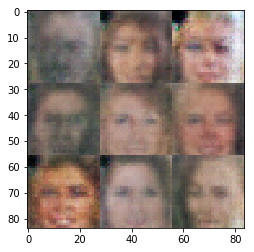

Epoch 1/1 Discriminator loss 0.3447 Generator loss 2.0313
Epoch 1/1 Discriminator loss 0.2423 Generator loss 4.1200


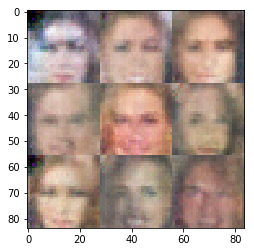

Epoch 1/1 Discriminator loss 0.2324 Generator loss 3.0235
Epoch 1/1 Discriminator loss 0.5308 Generator loss 4.8969


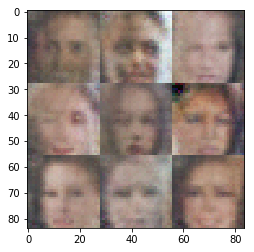

Epoch 1/1 Discriminator loss 0.0808 Generator loss 4.5885
Epoch 1/1 Discriminator loss 0.1311 Generator loss 4.2352


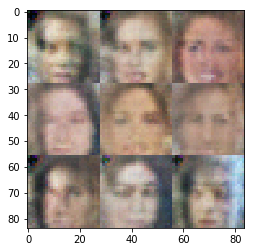

Epoch 1/1 Discriminator loss 0.2402 Generator loss 3.0179
Epoch 1/1 Discriminator loss 0.1783 Generator loss 3.0586


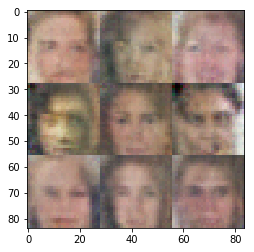

Epoch 1/1 Discriminator loss 0.2204 Generator loss 3.4291
Epoch 1/1 Discriminator loss 0.0269 Generator loss 9.5465


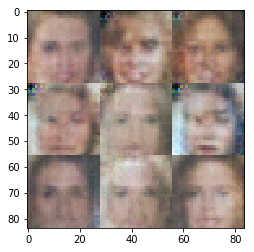

Epoch 1/1 Discriminator loss 0.1688 Generator loss 3.3208
Epoch 1/1 Discriminator loss 0.2725 Generator loss 2.6436


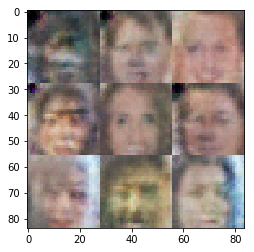

Epoch 1/1 Discriminator loss 0.1857 Generator loss 3.7366
Epoch 1/1 Discriminator loss 0.0924 Generator loss 3.5396


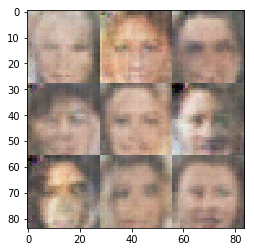

Epoch 1/1 Discriminator loss 0.2151 Generator loss 2.6722
Epoch 1/1 Discriminator loss 0.2843 Generator loss 3.4831


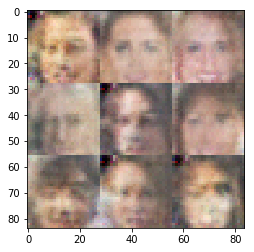

Epoch 1/1 Discriminator loss 0.7980 Generator loss 1.3159
Epoch 1/1 Discriminator loss 0.1066 Generator loss 4.9470


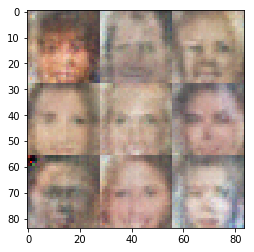

Epoch 1/1 Discriminator loss 0.1486 Generator loss 3.4492
Epoch 1/1 Discriminator loss 0.1583 Generator loss 4.3534


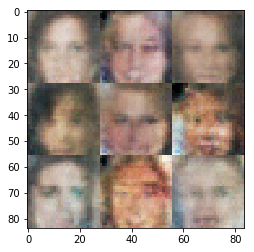

Epoch 1/1 Discriminator loss 0.0809 Generator loss 5.6298
Epoch 1/1 Discriminator loss 0.0766 Generator loss 5.2707


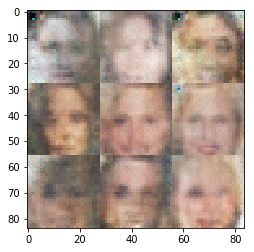

Epoch 1/1 Discriminator loss 0.0625 Generator loss 5.9307
Epoch 1/1 Discriminator loss 0.0672 Generator loss 4.9996


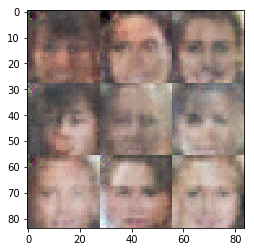

Epoch 1/1 Discriminator loss 0.0671 Generator loss 4.6398
Epoch 1/1 Discriminator loss 0.2916 Generator loss 2.5637


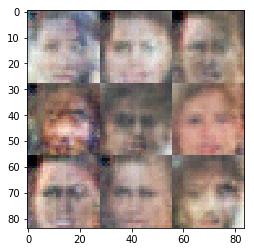

Epoch 1/1 Discriminator loss 0.0736 Generator loss 6.6720
Epoch 1/1 Discriminator loss 0.1277 Generator loss 4.1788


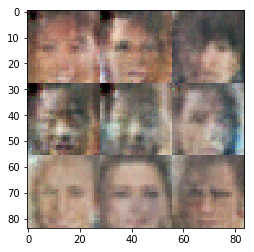

Epoch 1/1 Discriminator loss 0.0462 Generator loss 5.3401
Epoch 1/1 Discriminator loss 0.0912 Generator loss 3.9738


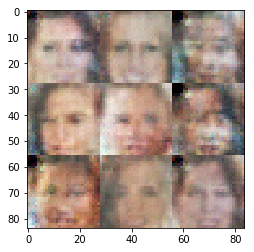

Epoch 1/1 Discriminator loss 0.0608 Generator loss 4.5513
Epoch 1/1 Discriminator loss 0.3097 Generator loss 2.5150


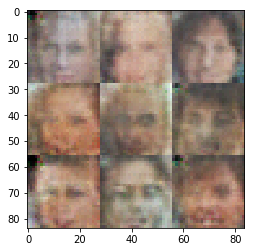

Epoch 1/1 Discriminator loss 0.1798 Generator loss 3.6418
Epoch 1/1 Discriminator loss 0.2047 Generator loss 2.9530


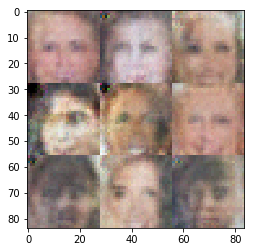

Epoch 1/1 Discriminator loss 0.0150 Generator loss 7.6645
Epoch 1/1 Discriminator loss 0.0390 Generator loss 4.9721


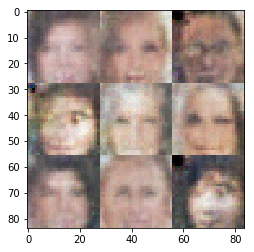

IndexError: list index out of range

In [56]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
alpha = 0.2
beta1 = 0.5
real_size = (28,28,3) 



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    gan = GAN(real_size=real_size, z_size=z_dim, learning_rate=learning_rate, alpha=alpha, beta1=beta1)
    train(gan,epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.